In [1]:
#!/usr/bin/env python
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
import pandas as pd
from scipy.stats import pearsonr,spearmanr

import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots

rez=600


In [123]:
#class to keep information about a single participant
class participant:

    #initialize participant class
    def __init__(self, name, et, tF, stop2, A0, vdp, pkp, pdp, v_flg):
        
        self.v_flg = v_flg #Boolean flag, if True prints stuff out during sim

        self.dose_interval = 56 #how often bnabs are dosed (days)
        self.obs_interval = 28 #how often measurements are observed (days)
        
        self.tF=tF #maximum time of sim, gets changed later...
        self.obs=np.zeros([int(np.ceil(self.tF/self.obs_interval)+2)]) #list for observed viral loads 21 visits including day 0, extra for positive on 21st visit
        self.obs_times = np.arange(0,len(self.obs))*self.obs_interval

        self.name = name #ppt name, usually a number when looping in a trial
        self.et = et #exposure time            
        self.ttd = 0 #time to detection, initialize
        
        self.exp_int=2-np.ceil(self.et/self.obs_interval)%2 #exposure interval 1st (fp=1) or 2nd (fp=2) interval
        
        self.stop2 = stop2 #make the sim stop after 2 positives if True
        self.A0 = A0 #initial number of infected cells

        self.ct=0; self.bt=0 #initialize clearance and breakthru times
        self.fp_int=0 #first positive time in 1st (fp=1) or 2nd (fp=2) interval, or stays 0 if no first pos
        self.fp_vl=0 #first positive viral load
        
        self.rl=np.zeros(20); self.T=np.zeros([7,20]);  #initialize state/rate matrices
        self.dt=0.01 #timestep for tauleap
        
        self.set_parameters(vdp,pkp,pdp) #set to standard values first
            
        self.pk0,self.In0=self.ab_sim(self.et); #calculate concentration at transmission

    #enables user supplied parameter set
    def set_parameters(self, vdp, pkp, pdp):
    
        #start at control case, no bnabs at all
        #self.Y1,self.Y2,self.k1,self.k2,self.h,self.IC50 = 1e-10,0,0,0,1,1e10 #note h=1 otherwise weird 0^0 problem
        
        #set all values at a good model parameter set
        vol=1e8
        self.vol = vol        #volume of blood [uL]
        self.aS  = 70*vol;    #constant growth rate of susceptibles [cells/uL/day]
        self.Bt0 = 1e-4/vol   #infection rate of T-cells [uL/cells-day]/[uL]
        self.dA  = 0.8        #active death rate [1/day]
        self.p   = 5e4        #burst rate of virus from cells [virions/cell]
        self.g   = 23         #virus clearance rate [1/day]
        self.lam = 1e-4       #latency probability []
        self.thL = 5.2e-4     #latent clearance rate [1/day]
        self.aE  = 1e-5*vol;  #initial E cell concentration [cells/uL]*[uL]
        self.aL  = 0.015;     #latent proliferation rate [1/day] (Tcm)
        self.ksi = 1e-5;      #latent activation rate [1/day]
        self.dL  = self.aL-self.thL-self.ksi #latent death rate

        #initial values, will be reset by supplied list
        self.dS  = 0.3;       #susceptible death rate [1/day] 
        self.tau = 0.06       #productive infection probability []
        self.kap = 1/vol;     #immune cell killing rate [uL/cell-day]/[uL]
        self.dE  = 0.002;     #immune death rate [1/day]
        self.E50 = 250*vol;   #50 pct max E cell concentration [cells/uL]*[uL]
        self.w   = 1.6;       #immune cell multiplier [1/day]

        R0,self.dS,self.tau,kap,self.dE,E50,self.w=vdp 
        self.kap=kap/self.vol
        self.E50=E50*self.vol
        
        self.Y1,self.k1,self.Y2,self.k2=pkp
        self.IC50,self.h=pdp #note swap

    #calculate Ab model at any time (note dosing interval mod)
    def ab_sim(self,t):
        Y_t = self.Y1*np.exp(-self.k1*(t%self.dose_interval))+self.Y2*np.exp(-self.k2*(t%self.dose_interval))
        I_t = 1/(1+(self.IC50/Y_t)**self.h)
        return Y_t,I_t    
    
    #function that updates stochastic rates/transitions
    def update_rates(self, ti, xi):

        S,AU,AP,LU,LP,E,V=xi; #i-th state, easier to read if variables actually spelled out
    
        [vdp, pkp, pdp]=self.return_param_list()
        aS,dS,Bt0,tau,lam,dA,thL,aL,dL,ksi,kap,aE,dE,E50,w,p,g=vdp
        Y1,k1,Y2,k2=pkp
        IC50,h=pdp 

        Y_t,I_t=self.ab_sim(ti); Bt=Bt0*(1-I_t) #recalculate infectivity based on bnabs
        
        pr=np.random.poisson(p) #burst size randomized a bit

        self.rl[0] = aS;                     self.T[:,0] =[1,0,0,0,0,0,0];  #constant production 
        self.rl[1] = dS*S;                   self.T[:,1] =[-1,0,0,0,0,0,0]  #density dependent susceptible death
        self.rl[2] = (1-tau)*(1-lam)*Bt*S*V; self.T[:,2] =[-1,1,0,0,0,0,-1] #unproductive active infection
        self.rl[3] = tau*(1-lam)*Bt*S*V;     self.T[:,3] =[-1,0,1,0,0,0,-1] #productive active infection
        self.rl[4] = (1-tau)*lam*Bt*S*V;     self.T[:,4] =[-1,0,0,1,0,0,-1] #unproductive latent infection
        self.rl[5] = tau*lam*Bt*S*V;         self.T[:,5] =[-1,0,0,0,1,0,-1] #productive latent infection
        self.rl[6] = dA*AU;                  self.T[:,6] =[0,-1,0,0,0,0,0]  #unproductive active death
        self.rl[7] = dA*AP;                  self.T[:,7] =[0,0,-1,0,0,0,pr]  #productive active death and virus burst
        self.rl[8] = dL*LU;                  self.T[:,8] =[0,0,0,-1,0,0,0]  #unproductive latent death
        self.rl[9] = dL*LP;                  self.T[:,9] =[0,0,0,0,-1,0,0]  #productive latent death
        self.rl[10] = aL*LU;                 self.T[:,10]=[0,0,0,1,0,0,0]  #unproductive latent proliferation
        self.rl[11] = aL*LP;                 self.T[:,11]=[0,0,0,0,1,0,0]  #productive latent proliferation
        self.rl[12] = ksi*LU;                self.T[:,12]=[0,1,0,-1,0,0,0]  #unproductive latent activation
        self.rl[13] = ksi*LP;                self.T[:,13]=[0,0,1,0,-1,0,0]  #productive latent activation
        self.rl[14] = kap*E*AU;              self.T[:,14]=[0,-1,0,0,0,0,0]  #unproductive active immune removal
        self.rl[15] = kap*E*AP;              self.T[:,15]=[0,0,-1,0,0,0,0]  #productive active immune removal
        self.rl[16] = w*E*(AP+AU)/(E+E50);   self.T[:,16]=[0,0,0,0,0,1,0]  #immune cell recruitment
        self.rl[17] = aE;                    self.T[:,17]=[0,0,0,0,0,1,0]  #immune cell birth
        self.rl[18] = dE*E;                  self.T[:,18]=[0,0,0,0,0,-1,0]  #immune cell clearance
        self.rl[19] = g*V;                   self.T[:,19]=[0,0,0,0,0,0,-1]  #innate viral clearance

    #function that solves stochastically using tau-leap method
    def vd_sim(self):
                
        if self.v_flg:
            print('ppt:',self.name,', exposed:',self.et,', transmission ratio (conc/IC50):',self.pk0/self.IC50) #print info!
        
        tl=[0, self.et]; #initial time list
        
        #initial state list
        S0=self.aS/self.dS
        E0=self.aE/self.dE
        xl=[np.array([S0,0,0,0,0,E0,0]),np.array([S0,0,self.A0,0,0,E0,0])]; #initial state matrix

        obs_ind=int(np.floor(self.et/self.obs_interval)) #set index at most recent observation time pre-exposure
        fp_ind=0 #index for first observed viral load (if any)
        
        t_ind=1; ti=tl[t_ind] #counter for dt, start on second when et happens
        
        #loop over time 
        while ti<self.tF:
            xi=xl[t_ind]; ti=tl[t_ind]
            
            #breaking criteria for clearance, all sell states and virus = 0
            if (sum(xi[1:5])+xi[6])==0:
                self.ct=ti
                if self.v_flg:
                    print('clearance:',self.ct)
                break
                        
            #breaking criteria for breakthrough infection
            vl=xi[6]/self.vol*1e3; #viral load in copies/mL of blood (implies "instant" lymph trafficking to blood)
            if vl>30 and self.bt==0: 
                self.bt=ti; #breakthru time
                if self.v_flg:
                    print('breakthrough:',self.bt)
                if self.stop2:
                    self.tF=4*7*(np.ceil(self.bt/(4*7))+1)+self.dt; #change the end point (days) to be after 2 visits (as required, first pos and confirmatory)

            #do the observations!
            if ti>(obs_ind*self.obs_interval):
                self.obs[obs_ind]=vl
                obs_ind+=1
                if vl>30 and fp_ind==0:
                    self.fp_int=2-obs_ind%2 #first positive time in 1st (fp=1) or 2nd (fp=2) interval
                    self.fp_vl=vl #first positive viral load
                    self.ttd=ti-self.et #time to detection (days)
                    fp_ind+=1
            
            self.update_rates(ti,xi) #make new rate/transition matrices vector
            events=np.random.poisson(self.rl*self.dt) #calculate events
            xi=xi+np.sum(self.T*events,1); xi[xi<0]=0 #update state variable and make sure no negative numbers
            ti=ti+self.dt
            xl.append(xi); tl.append(ti) #the list of states
            t_ind+=1

        return np.array(tl),np.array(xl)
            
    #helper because want lists sometimes
    def return_param_list(self):
        vd_params=(self.aS,self.dS,self.Bt0,self.tau,self.lam,self.dA,self.thL,self.aL,self.dL,
                        self.ksi,self.kap,self.aE,self.dE,self.E50,self.w,self.p,self.g)
        pk_params=self.Y1,self.k1,self.Y2,self.k2
        pd_params=self.IC50,self.h
        return vd_params, pk_params, pd_params



ppt: 1 , exposed: 50 , transmission ratio (conc/IC50): 1e-10
breakthrough: 58.93999999999822


/Users/danielreeves/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


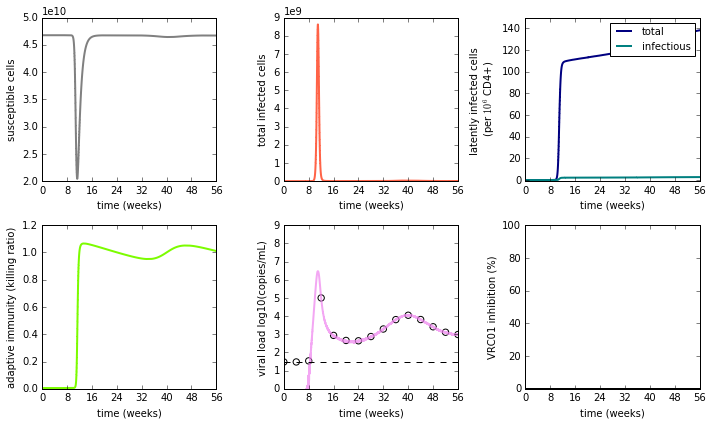

In [55]:
#simple tests for single participant without VRC01

VD=np.array(pd.DataFrame.from_csv('data/viral_dynamics.csv'))
p1=participant(name=1, et=50, tF=560, stop2=False, A0=1, vdp=VD[1,:], pkp=[1e-5,0,0,0], pdp=[1e5,1], v_flg=True)

t,sol=p1.vd_sim()

tAb = np.linspace(0,560,1e3) #time for antibody dose

plt.figure(figsize=(10,6),dpi=rez)

plt.subplot(231)
plt.step(t/7,sol[:,0],lw=2,color='gray')

plt.subplot(232)
plt.step(t/7,sol[:,1]+sol[:,2],lw=2,where='post',color='tomato') #all infected
#plt.ylim([0,100])

plt.subplot(233)
plt.step(t/7,(sol[:,3]+sol[:,4])/sol[0,0]*1e6,lw=2,color='navy') #divide by S0 (CD4+ T cells) and then multiply by 1 million
plt.step(t/7,sol[:,4]/sol[0,0]*1e6,lw=2,color='teal') #divide by S0 (CD4+ T cells) and then multiply by 1 million
plt.legend(['total','infectious'],fontsize=10)
plt.ylim([-1,150])

plt.subplot(234)
plt.step(t/7,sol[:,5]*p1.kap/p1.dA,color='lawngreen',lw=2)

plt.subplot(235)
vll=np.log10(sol[:,6]/p1.vol*1e3+1e-3)
plt.step(t/7,vll,lw=2,color='violet',alpha=0.7)
plt.scatter(p1.obs_times/7,np.log10(p1.obs+30),facecolors='none',edgecolors='k',s=40)
plt.axhline(np.log10(30),color='k',ls='--')
plt.ylim([0,9])

Y_t,I_t=p1.ab_sim(tAb)
plt.subplot(236)
plt.plot(tAb/7,I_t*100,lw=2,color='k')
plt.ylim([0,100])

#run on last ppt

labelz=['susceptible cells','total infected cells',
    'latently infected cells \n (per $10^6$ CD4+)','adaptive immunity (killing ratio)',
    'viral load log10(copies/mL)','VRC01 inhibition (%)']
for ii in range(6):
    plt.subplot(231+ii)
    plt.xlabel('time (weeks)')
    plt.ylabel(labelz[ii])
    plt.xticks(p1.obs_times[::2]/7)
    plt.xlim([0,56])

plt.tight_layout()
plt.savefig('figures/ex_ctl.pdf')


ppt: 1 , exposed: 50 , transmission ratio (conc/IC50): 5.70579578874
clearance: 55.63999999999888


/Users/danielreeves/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


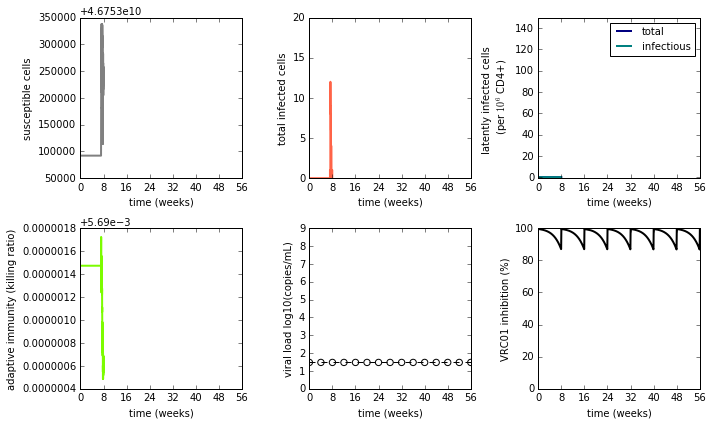

In [54]:
#simple tests for single participant with VRC01

PK=np.array(pd.DataFrame.from_csv('data/PK10.csv'))
PD=np.array(pd.DataFrame.from_csv('data/PDall.csv'))
p1=participant(name=1, et=50, tF=560, stop2=False, A0=1, vdp=VD[1,:], pkp=PK[2,:], pdp=PD[97,:], v_flg=True)

t,sol=p1.vd_sim()

tAb = np.linspace(0,560,1e3) #time for antibody dose

plt.figure(figsize=(10,6),dpi=rez)

plt.subplot(231)
plt.step(t/7,sol[:,0],lw=2,color='gray')

plt.subplot(232)
plt.step(t/7,sol[:,1]+sol[:,2],lw=2,where='post',color='tomato') #all infected
plt.ylim([0,20])

plt.subplot(233)
plt.step(t/7,(sol[:,3]+sol[:,4])/sol[0,0]*1e6,lw=2,color='navy') #divide by S0 (CD4+ T cells) and then multiply by 1 million
plt.step(t/7,sol[:,4]/sol[0,0]*1e6,lw=2,color='teal') #divide by S0 (CD4+ T cells) and then multiply by 1 million
plt.legend(['total','infectious'],fontsize=10)
plt.ylim([-1,150])

plt.subplot(234)
plt.step(t/7,sol[:,5]*p1.kap/p1.dA,color='lawngreen',lw=2)

plt.subplot(235)
vll=np.log10(sol[:,6]/p1.vol*1e3+1e-3)
plt.step(t/7,vll,lw=2,color='violet',alpha=0.7)
plt.scatter(p1.obs_times/7,np.log10(p1.obs+30),facecolors='none',edgecolors='k',s=40)
plt.axhline(np.log10(30),color='k',ls='--')
plt.ylim([0,9])

Y_t,I_t=p1.ab_sim(tAb)
plt.subplot(236)
plt.plot(tAb/7,I_t*100,lw=2,color='k')
plt.ylim([0,100])

#run on last ppt

labelz=['susceptible cells','total infected cells',
    'latently infected cells \n (per $10^6$ CD4+)','adaptive immunity (killing ratio)',
    'viral load log10(copies/mL)','VRC01 inhibition (%)']
for ii in range(6):
    plt.subplot(231+ii)
    plt.xlabel('time (weeks)')
    plt.ylabel(labelz[ii])
    plt.xticks(p1.obs_times[::2]/7)
    plt.xlim([0,56])

plt.tight_layout()
plt.savefig('figures/ex_VRC01.pdf')


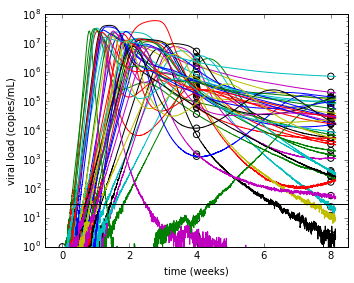

In [58]:
#try all viral dynamics parameter sets without VRC01 in a single dose interval
VD=np.array(pd.DataFrame.from_csv('data/viral_dynamics.csv'))

etf=0 #how to space out for plotting
plt.figure(figsize=(5,4),dpi=rez)
for i in range(len(VD)):
    p=participant(name=1, et=i*etf, tF=8*7+1, stop2=False, A0=1, 
                  vdp=VD[i,:], pkp=[1e-5,0,0,0], pdp=[1e5,1], v_flg=False)

    t,sol=p.vd_sim()
    plt.semilogy(t/7,sol[:,6]/p.vol*1e3)
    plt.scatter(p.obs_times/7,p.obs+0.7**i,facecolors='none',edgecolors='k',s=40)

plt.xlabel('time (weeks)')
plt.ylabel('viral load (copies/mL)')
plt.ylim([1,1e8])
plt.yticks(np.logspace(0,8,9))
plt.axhline(30,color='k')
plt.tight_layout()
plt.xlim([-0.5,8.5])

plt.tight_layout()
plt.savefig('figures/ex_allsets.pdf')


In [124]:
#class for simulating trials
class trial:
    def __init__(self, name, nps, tF, dose, clade, A0, iv_phi, maxIC50, v_flg, keep_flg):
        
        self.name=name; self.nps=nps; self.tF=tF; self.dose=dose; self.clade=clade; #trial information

        self.v_flg=v_flg #verbose flag, usually False
        self.keep_flg = keep_flg #keep all observations if 1, keep all ppts if 2
        
        self.A0=A0; self.iv_phi=iv_phi; self.maxIC50=maxIC50 #variables for sensitivity analysis

        #import parameters and update for sensitivity
        self.VD=np.array(pd.DataFrame.from_csv('data/viral_dynamics.csv'))
        if dose!=0:
            self.PK=np.array(pd.DataFrame.from_csv('data/PK'+str(self.dose)+'.csv'))
            PD=np.array(pd.DataFrame.from_csv('data/PD'+self.clade+'.csv'))
            
            #update PD for sensitivity
            if self.maxIC50 > 50:
                PD[PD[:,0]>49,0]=50+np.random.random([sum(PD[:,0]>49)])*self.maxIC50 #reset to max IC50
            if self.iv_phi > 1:
                PD[:,0]=PD[:,0]*self.iv_phi            
            self.PD=PD #set vals        

        #containers for output variables
        self.texp=np.zeros([nps]); #time of exposure (days)
        self.ttds=np.zeros([nps]); #time of detection (days)
        self.fp_ints=np.zeros([nps]); #first pos detected index (0,1,2 for never interval1 and interval 2 respectively)
        self.fp_vls=np.zeros([nps]); #first pos detected viral load
        self.brks=np.zeros([nps]);  self.clrs=np.zeros([nps]); #time of brks and clrs(days)
        self.bt_ic50s=np.zeros([nps]); self.bt_ic50fs=np.zeros([nps]) #IC50s of breakthru strains
        
        self.obz=[[],[]] #for t and obs lists, only filled if keep_flg>0
        self.sim=[[],[]] #for t and sol lists, only filled if keep_flg>1
        self.run_trial() #run!
        
    #functino to run the trial
    def run_trial(self):
        #loop ppts with random samples from PK, PD, and viral dynamics data, random t0
        for n in range(self.nps):
            t0=np.random.rand()*self.tF #random time of crossing mucosal barrierr

            vdp=self.VD[np.random.randint(len(self.VD)),:]

            #allow for control trial
            if self.dose==0:
                pkp=[1e-5,0,0,0];
                pdp=[1e5,1];        
            else:
                pkp=self.PK[np.random.randint(len(self.PK)),:]
                pdp=self.PD[np.random.randint(len(self.PD)),:]
            
            ppt=participant(name=n, A0=self.A0, et=t0, tF=self.tF, stop2=True, vdp=vdp, pkp=pkp, pdp=pdp, v_flg=False)
            t,sol=ppt.vd_sim() #simulate ppt transmission event

            #verbose print outs
            if self.v_flg:
                print('name:',ppt.name,
                      'conc ratio:',ppt.pk0/ppt.IC50,
                      'first pos int:',ppt.fp_int,
                      'first pos VL:',ppt.fp_vl)
            
            self.texp[n]      = ppt.et #exposure time
            self.fp_ints[n]   = ppt.fp_int #first positive intervals
            self.fp_vls[n]    = ppt.fp_vl #first positive viral loads
            self.brks[n]      = ppt.bt #true breakthrough time
            self.clrs[n]      = ppt.ct #true clearance time
            self.ttds[n]      = ppt.ttd #time to detection
            self.bt_ic50s[n]  = ppt.IC50 #breakthrough IC50
            self.bt_ic50fs[n] = ppt.pk0/ppt.IC50 #breakthrough concentration ratio
                
            if self.keep_flg>0:
                self.obz[0].append(ppt.obs_times)
                self.obz[1].append(ppt.obs)
                if self.keep_flg>1:
                    self.sim[0].append(t)
                    self.sim[1].append(np.log10(sol[:,6]/ppt.vol*1e3+1e-3))

        #could convert to arrays here...
        #self.fp_ints=np.array(self.fp_ints)
        #self.fp_vls=np.array(self.fp_vls)

name: 0 conc ratio: 116.122247111 exp int: 1.0 first pos int: 0 first pos VL: 0
name: 1 conc ratio: 3.35466636451 exp int: 2.0 first pos int: 0 first pos VL: 0
name: 2 conc ratio: 0.142880260746 exp int: 2.0 first pos int: 2 first pos VL: 1916504.50206
name: 3 conc ratio: 12.8121866742 exp int: 1.0 first pos int: 0 first pos VL: 0
name: 4 conc ratio: 1.02452400445 exp int: 1.0 first pos int: 2 first pos VL: 203.2665
name: 5 conc ratio: 12.0960420966 exp int: 1.0 first pos int: 0 first pos VL: 0
name: 6 conc ratio: 44.8040642337 exp int: 1.0 first pos int: 0 first pos VL: 0
name: 7 conc ratio: 0.314063910578 exp int: 2.0 first pos int: 1 first pos VL: 54922.42181
name: 8 conc ratio: 138.492162712 exp int: 2.0 first pos int: 0 first pos VL: 0
name: 9 conc ratio: 32.7406606127 exp int: 2.0 first pos int: 0 first pos VL: 0
CPU times: user 2.15 s, sys: 4.35 ms, total: 2.15 s
Wall time: 2.15 s


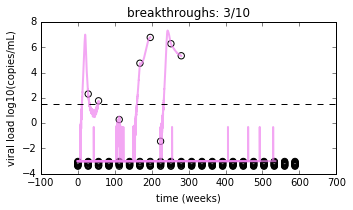

In [87]:
#now simple test of trial including VRC01
%time tr=trial(name='test', nps=10, tF=560, dose=10, clade='B', A0=1, iv_phi=1, maxIC50=50, v_flg=True, keep_flg=2)

#plot trial outcome
plt.figure(figsize=(5,3),dpi=rez)
for ip in range(tr.nps):
    plt.scatter(tr.obz[0][ip],np.log10(tr.obz[1][ip]+4e-4*1.1**ip),facecolors='none',edgecolors='k',s=40)#,c=plt.cm.jet(ip))#1.4**ip),alpha=0.7)
    plt.plot(tr.sim[0][ip],tr.sim[1][ip],lw=2,color='violet',alpha=0.7)
    
plt.axhline(np.log10(30),color='k',ls='--')
plt.ylim([-4,8])
plt.ylabel('viral load log10(copies/mL)')
plt.xlabel('time (weeks)')
plt.title('breakthroughs: '+str(len(tr.brks))+'/'+str(tr.nps))
plt.tight_layout()
plt.savefig('figures/trial_test.pdf')

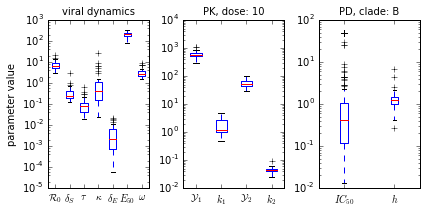

In [94]:
#just to check on parameters
plt.figure(figsize=(6,3),dpi=rez)

plt.subplot(131)
plt.boxplot(tr.VD)
plt.semilogy()
plt.xticks(np.arange(7)+1,
           [r'$\mathcal{R}_0$',r'$\delta_S$',r'$\tau$',r'$\kappa$',r'$\delta_E$',r'$E_{50}$',r'$\omega$'])
plt.ylabel('parameter value')
plt.title('viral dynamics',fontsize=10)

plt.subplot(132)
plt.boxplot(tr.PK)
plt.semilogy()
plt.xticks(np.arange(4)+1,[r'$\mathcal{Y}_1$',r'$k_1$',r'$\mathcal{Y}_2$',r'$k_2$'])
plt.title('PK, dose: ' + str(tr.dose),fontsize=10)

plt.subplot(133)
plt.boxplot(tr.PD)
plt.semilogy()
plt.xticks(np.arange(2)+1,[r'$IC_{50}$',r'$h$'])
plt.title('PD, clade: ' + str(tr.clade),fontsize=10)

plt.tight_layout()
plt.savefig('figures/trial_params.pdf')

In [247]:
#first, control trial

N=500 #number of participants in each trial

%time tr_ctl=trial(name='ctl', nps=N, tF=560, dose=0, clade='all', A0=1, iv_phi=1, maxIC50=50, v_flg=False, keep_flg=2)


CPU times: user 3min 52s, sys: 515 ms, total: 3min 52s
Wall time: 3min 54s


In [180]:
#now do sensitivity analyses for phi
iv=np.logspace(0,4,10)
sens_iv=[]

counter=0
for ii in range(len(iv)):
    tr=trial(name='sense'+str(counter), nps=N, tF=560, dose=10, clade='all',
             A0=1, iv_phi=iv[ii], maxIC50=50, v_flg=False, keep_flg=0)
    sens_iv.append(tr)
    counter+=1
    print(counter)



1
2
3
4
5
6
7
8
9
10


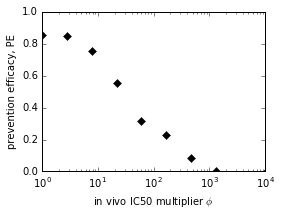

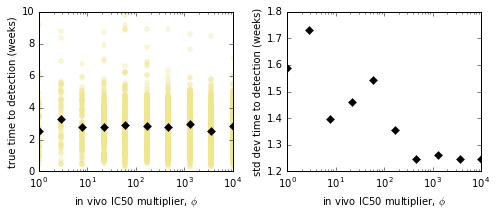

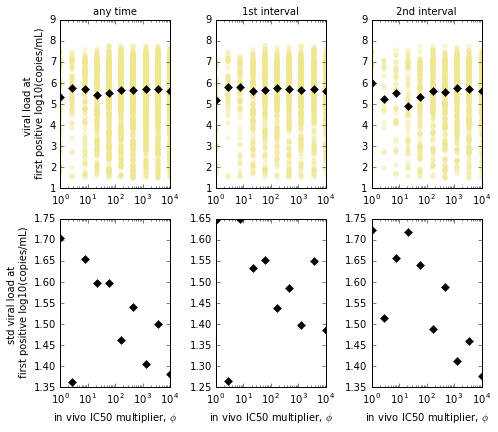

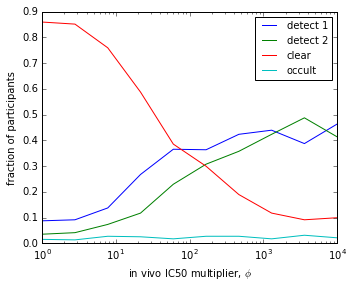

In [248]:
#make all the phi plots

#few extra variables
sens=sens_iv
nts=len(sens)
trials=range(nts)
alz=0.3
dotcolz='khaki'

#prevention efficacy plots
plt.figure(figsize=(4,3),dpi=rez)
brks=np.zeros([nts])
phi=np.zeros([nts])
for it in trials:    
    tr=sens[it]
    phi[it]=tr.iv_phi
    brks[it]=sum(tr.brks>0)
    
plt.semilogx(phi,1-brks/sum(tr_ctl.brks>0),color='k',marker='D',ls='')
plt.xlim([1,1e4])
plt.ylim([0,1])
plt.ylabel('prevention efficacy, PE')
plt.xlabel('in vivo IC50 multiplier $\phi$')

plt.tight_layout()
plt.savefig('figures/phi_PE')


#time to detection plots
plt.figure(figsize=(7,3),dpi=rez)
for it in trials:

    ttds=sens[it].ttds
    
    ttds=ttds[ttds>0]/7
    
    plt.subplot(121)
    s1=plt.scatter(np.zeros(len(ttds))+sens[it].iv_phi,ttds,alpha=alz,color=dotcolz)
    s2=plt.semilogx(sens[it].iv_phi,np.median(ttds),color='k',marker='D',ls='')
    plt.xlim([1,1e4])
    plt.ylim([0,10])
    plt.ylabel('true time to detection (weeks)')
    plt.xlabel('in vivo IC50 multiplier, $\phi$')
    
    plt.subplot(122)
    plt.semilogx(sens[it].iv_phi,np.std(ttds),color='k',marker='D',ls='')
    plt.xlim([1,1e4])
    plt.ylabel('std dev time to detection (weeks)')
    plt.xlabel('in vivo IC50 multiplier, $\phi$')

plt.tight_layout()
plt.savefig('figures/phi_ttd.pdf')


#viral load at detection plots
plt.figure(figsize=(7,6),dpi=rez)

brks1=np.zeros([nts])
brks2=np.zeros([nts])
clrs=np.zeros([nts])
phis=np.zeros([nts])

vlzA=[]
vlz4=[]
vlz8=[]

for it in trials:
    phis[it]=sens[it].iv_phi
    vlz=np.array(sens[it].fp_vls)
    
    vlzA=np.log10(vlz[vlz>0]+1e-4)
    vlz4=np.log10(vlz[sens[it].fp_ints==1]+1e-4)
    vlz8=np.log10(vlz[sens[it].fp_ints==2]+1e-4)
    
    brks1[it]=sum(sens[it].fp_ints==1)
    brks2[it]=sum(sens[it].fp_ints==2)
    clrs[it]=sum(sens[it].clrs>0)
    occls[it]=sens[it].nps-brks1[it]-brks2[it]-clrs[it]

    plt.subplot(231)
    plt.scatter(np.zeros(len(vlzA))+sens[it].iv_phi,vlzA,alpha=alz,color=dotcolz)
    plt.semilogx(sens[it].iv_phi,np.median(vlzA),color='k',marker='D',ls='')
    plt.xlim([1,1e4])
    plt.ylabel('viral load at \n first positive log10(copies/mL)')
    plt.title('any time',fontsize=10)

    plt.subplot(234)
    plt.semilogx(sens[it].iv_phi,np.std(vlzA),color='k',marker='D',ls='')
    plt.xlim([1,1e4])
    plt.ylabel('std viral load at \n first positive log10(copies/mL)')
    plt.xlabel('in vivo IC50 multiplier, $\phi$')

    plt.subplot(232)
    plt.scatter(np.zeros(len(vlz4))+sens[it].iv_phi,vlz4,alpha=alz,color=dotcolz)
    plt.semilogx(sens[it].iv_phi,np.median(vlz4),color='k',marker='D',ls='')
    plt.xlim([1,1e4])
    plt.title('1st interval',fontsize=10)

    plt.subplot(235)
    plt.semilogx(sens[it].iv_phi,np.std(vlz4),color='k',marker='D',ls='')
    plt.xlim([1,1e4])
    plt.xlabel('in vivo IC50 multiplier, $\phi$')

    plt.subplot(233)
    plt.scatter(np.zeros(len(vlz8))+sens[it].iv_phi,vlz8,alpha=alz,color=dotcolz)
    plt.semilogx(sens[it].iv_phi,np.median(vlz8),color='k',marker='D',ls='')
    plt.xlim([1,1e4])
    plt.title('2nd interval',fontsize=10)

    plt.subplot(236)
    plt.semilogx(sens[it].iv_phi,np.std(vlz8),color='k',marker='D',ls='')
    plt.xlim([1,1e4])
    plt.xlabel('in vivo IC50 multiplier, $\phi$')

plt.tight_layout()

## fractions in each interval
plt.figure(figsize=(5,4),dpi=rez)
plt.plot(phis,brks1/N)
plt.plot(phis,brks2/N)
plt.plot(phis,clrs/N)
plt.plot(phis,(N-brks1-brks2-clrs)/N)

plt.semilogx()
plt.ylabel('fraction of participants')
plt.xlabel('in vivo IC50 multiplier, $\phi$')
plt.legend(['detect 1','detect 2','clear','occult'],fontsize=10)
plt.tight_layout()
plt.savefig('figures/phi_ttd.pdf')


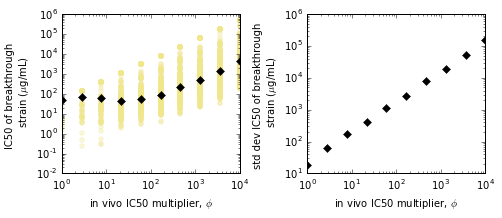

In [186]:
#breakthru IC50s
plt.figure(figsize=(7,3),dpi=rez)
for it in trials:
    iA=sens[it].bt_ic50s[sens[it].fp_ints>0]
  
    plt.subplot(121)
    s1=plt.scatter(np.zeros(len(iA))+sens[it].iv_phi,iA,alpha=alz,color=dotcolz)
    s2=plt.loglog(sens[it].iv_phi,np.median(iA),color='k',marker='D',ls='')
    plt.xlim([1,1e4])
    #plt.ylim([0,10])
    plt.ylabel('IC50 of breakthrough \n strain ($\mu$g/mL)')
    plt.xlabel('in vivo IC50 multiplier, $\phi$')
    
    plt.subplot(122)
    plt.loglog(sens[it].iv_phi,np.std(iA),color='k',marker='D',ls='')
    plt.xlim([1,1e4])
    plt.ylabel('std dev IC50 of breakthrough \n strain ($\mu$g/mL)')
    plt.xlabel('in vivo IC50 multiplier, $\phi$')

plt.tight_layout()
plt.savefig('figures/phi_ic50s')

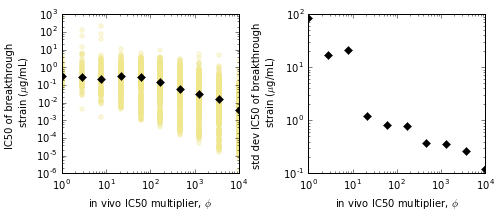

In [187]:
#breakthru IC50s fractions
plt.figure(figsize=(7,3),dpi=rez)
for it in trials:

    iA=sens[it].bt_ic50fs[sens[it].fp_ints>0]
  
    plt.subplot(121)
    s1=plt.scatter(np.zeros(len(iA))+sens[it].iv_phi,iA,alpha=alz,color=dotcolz)
    s2=plt.loglog(sens[it].iv_phi,np.median(iA),color='k',marker='D',ls='')
    plt.xlim([1,1e4])
    #plt.ylim([0,10])
    plt.ylabel('IC50 of breakthrough \n strain ($\mu$g/mL)')
    plt.xlabel('in vivo IC50 multiplier, $\phi$')
    
    plt.subplot(122)
    plt.loglog(sens[it].iv_phi,np.std(iA),color='k',marker='D',ls='')
    plt.xlim([1,1e4])
    plt.ylabel('std dev IC50 of breakthrough \n strain ($\mu$g/mL)')
    plt.xlabel('in vivo IC50 multiplier, $\phi$')

plt.tight_layout()
plt.savefig('figures/phi_ic50fs')

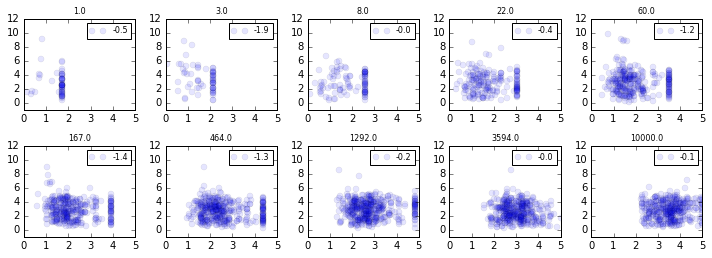

In [243]:
#but we are really interested in if time to detection 
#(allows estimate of exposure concentration) correlates with any observable variable!!

plt.figure(figsize=(10,7),dpi=rez)
for it in trials:        

    iA=np.log10(sens[it].bt_ic50s[sens[it].fp_ints>0])
    
    ttds=sens[it].ttds[sens[it].fp_ints>0]/7
    
    plt.subplot(4,5,it+1)
    plt.plot(iA,ttds,alpha=0.1,marker='o',lw=0)
    plt.title(np.round(sens[it].iv_phi),fontsize=8)
    plt.legend([str(np.round(np.log10(pearsonr(iA,ttds)[1]),1))],fontsize=8)
    plt.ylim([-1,12])
    plt.xlim([0,5])
    plt.xticks(range(0,6))

plt.tight_layout()
plt.savefig('figures/corr_ic50s')

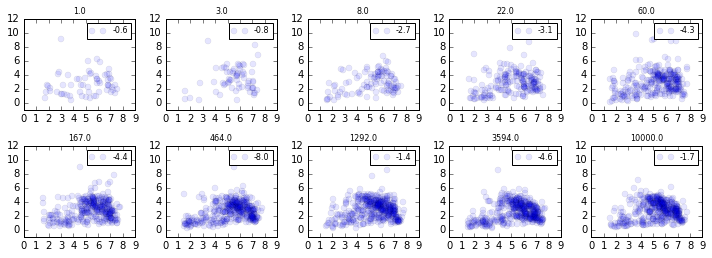

In [244]:
#but we are really interested in if time to detection 
#(allows estimate of exposure concentration) correlates with any observable variable!!

plt.figure(figsize=(10,7),dpi=rez)

for it in trials:    
    vlz=np.log10(sens[it].fp_vls[sens[it].fp_ints>0])
    ttds=sens[it].ttds[sens[it].fp_ints>0]/7
    
    #maybe should do this for each interval? see which is more predictive?
    #vlz4=np.log10(vlz[np.array(sens[it].fp_ints)==1])
    #vlz8=np.log10(vlz[np.array(sens[it].fp_ints)==2])

    plt.subplot(4,5,it+1)
    plt.plot(vlz,ttds,alpha=0.1,marker='o',lw=0)
    plt.title(np.round(sens[it].iv_phi),fontsize=8)
    plt.legend([str(np.round(np.log10(pearsonr(vlz,ttds)[1]),1))],fontsize=8)
    #plt.semilogx()
    plt.ylim([-1,12])
    plt.xlim([0,9])

plt.tight_layout()
plt.savefig('figures/corr_VL')

In [224]:
#compare trials with sort of kaplan meier thingy

#first, control trial

N=100 #number of participants in each trial

%time tr_ctl=trial(name='ctl', nps=N, tF=560, dose=0, clade='all', A0=1, iv_phi=1, maxIC50=50, v_flg=False, keep_flg=2)
%time tr_10B=trial(name='ctl', nps=N, tF=560, dose=10, clade='B', A0=1, iv_phi=1, maxIC50=50, v_flg=False, keep_flg=2)
%time tr_10C=trial(name='ctl', nps=N, tF=560, dose=10, clade='C', A0=1, iv_phi=1, maxIC50=50, v_flg=False, keep_flg=2)
%time tr_30B=trial(name='ctl', nps=N, tF=560, dose=30, clade='B', A0=1, iv_phi=1, maxIC50=50, v_flg=False, keep_flg=2)
%time tr_30C=trial(name='ctl', nps=N, tF=560, dose=30, clade='C', A0=1, iv_phi=1, maxIC50=50, v_flg=False, keep_flg=2)



CPU times: user 47.4 s, sys: 53.9 ms, total: 47.4 s
Wall time: 47.5 s
CPU times: user 6.09 s, sys: 6.65 ms, total: 6.1 s
Wall time: 6.13 s
CPU times: user 9.33 s, sys: 10.8 ms, total: 9.34 s
Wall time: 9.37 s
CPU times: user 4.58 s, sys: 4.49 ms, total: 4.59 s
Wall time: 4.59 s
CPU times: user 8.87 s, sys: 12.4 ms, total: 8.88 s
Wall time: 8.89 s


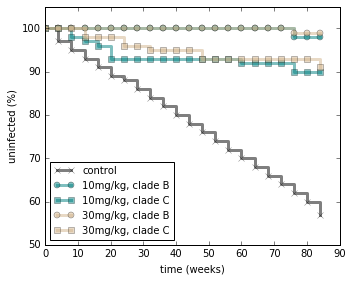

In [246]:
trl=[tr_ctl,tr_10B,tr_10C,tr_30B,tr_30C]
colz=['k','teal','teal','tan','tan']
lz=['-',':','-',':','-']
mz=['x','o','s','o','s']
trz=['control','10mg/kg, clade B','10mg/kg, clade C','30mg/kg, clade B','30mg/kg, clade C']
plt.figure(figsize=(5,4),dpi=rez)
for i in range(len(trl)):
    tr=trl[i]
    obs_t=tr.obz[0][0]
    pct_u=np.zeros([len(obs_t)])
    u=N
    for tt in range(len(obs_t)):
        pct_u[tt]=u/N*100
        u=u-np.sum(tr.obz[1][tt]>0)
    
    plt.step(obs_t/7,pct_u,where='post',lw=3,color=colz[i],marker=mz[i],alpha=0.5)
    #plt.step(obs_t/7,pct_u,where='post',lw=3,color=plt.cm.cool(i/len(trl)),ls=lz[i],alpha=0.5)
plt.ylabel('uninfected (%)')
plt.xlabel('time (weeks)')
plt.legend(trz,fontsize=10,loc=3)
plt.ylim([50,105])
plt.tight_layout()
plt.savefig('figures/kaplanM')